# Introduction

Welcome to Aurora AI! 🌟 In this notebook, we stress-test the long-context window capability of Google's Gemini 1.5 Flash model, crafting a cutting-edge personalized AI assistant designed to grow with you. Aurora not only provides highly tailored suggestions based on your goals and preferences but also ensures privacy, transparency, and responsible AI usage.

# Why Long Context Matters
Long-context AI models like Gemini 1.5 can:

Understand complex interactions over time, from user behavior to long-term trends.
Blend public and private data to provide more accurate and contextual suggestions.
Maintain user-specific history to ensure evolving recommendations.

# The Goal:
By leveraging long-context, this project challenges Gemini 1.5 Flash to provide contextually-rich, personalized suggestions while integrating both public trends and private user preferences.

# 1. Load & Preprocess Data
In order to stress-test Gemini 1.5, we first load public data such as trending topics and influencer data. This serves as the foundation for generating real-time, highly relevant suggestions.

In [1]:
import pandas as pd

# File path 
file_path = '/kaggle/input/ai-generated-influencer-data/influencer_data.jsonl'

# Load the JSON Lines file into a DataFrame
df = pd.read_json(file_path, lines=True)

# Display the first few rows
print("Data Loaded Successfully!") 

Data Loaded Successfully!


In [2]:
!pip install -q google-generativeai
import os
import time
import datetime
import google.generativeai as genai
from google.generativeai import caching

# 2. Initialize Gemini API
Here we configure Gemini 1.5 with the user's Google API key to begin querying the model for context-aware insights.



In [3]:
import os
import time
import datetime
import google.generativeai as genai
from google.generativeai import caching
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
genai.configure(api_key = GOOGLE_API_KEY) 
print("Gemini API configured successfully!")

Gemini API configured successfully!


# 3. Combine Public and Private Data
We combine public data (e.g., trending hashtags, optimal posting times) with private user preferences stored in a SQLite database. This allows for personalized suggestions based on both global trends and individual user data.

Public Data (Trending Hashtags, Posting Times):

In [4]:
# Sample public trends data
trends = {
    "fitness": ["#FitnessMotivation", "#HealthyLiving", "#WorkoutGoals"],
    "travel": ["#TravelDiaries", "#Wanderlust", "#TravelTuesday"],
    "tech": ["#TechTrends", "#Innovation", "#AIRevolution"],
    "food": ["#FoodieLife", "#Tasty", "#RecipeOfTheDay"]
}

# Optimal posting hours for different days of the week
engagement_hours = {
    "Monday": [9, 12, 18],
    "Tuesday": [10, 13, 19],
    "Wednesday": [8, 14, 20],
    "Thursday": [9, 15, 21],
    "Friday": [11, 16, 22],
    "Saturday": [10, 14, 18],
    "Sunday": [12, 15, 19]
}

# Function to fetch trending hashtags based on niche
def get_trending_hashtags(niche):
    return trends.get(niche.lower(), [])

# Function to suggest optimal posting times based on the day
def get_posting_times(day=None):
    if day is None:
        day = datetime.datetime.now().strftime("%A")
    hours = engagement_hours.get(day, [])
    if hours:
        times = [f"{hour}:00" for hour in hours]
        return f"Best times to post on {day}: {', '.join(times)}"
    else:
        return "No data available for the best posting times."


**Private Data (User Preferences)**:

In [5]:
import sqlite3

# Create a database for storing user preferences
def initialize_db():
    conn = sqlite3.connect("aurora_user_data.db")
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS user_preferences (
            id INTEGER PRIMARY KEY,
            user_name TEXT,
            preferred_niche TEXT,
            goal TEXT,
            favorite_hashtags TEXT,
            engagement_hours TEXT
        )
    ''')
    conn.commit()
    conn.close()

# Function to save user preferences
def save_user_data(user_name, preferred_niche, goal, favorite_hashtags, engagement_hours):
    conn = sqlite3.connect("aurora_user_data.db")
    cursor = conn.cursor()
    cursor.execute('''
        INSERT INTO user_preferences (user_name, preferred_niche, goal, favorite_hashtags, engagement_hours)
        VALUES (?, ?, ?, ?, ?)
    ''', (user_name, preferred_niche, goal, favorite_hashtags, engagement_hours))
    conn.commit()
    conn.close()

# Save preferences for 'Monica'
initialize_db()
save_user_data(
    user_name="Monica",
    preferred_niche="fitness",
    goal="grow_followers",
    favorite_hashtags="#FitnessGoals, #WorkoutLife",
    engagement_hours="9 AM, 12 PM, 6 PM"
)


# 4. Efficient Long-Context Handling for 100,000+ Tokens
Since Gemini 1.5 can handle large contexts, we aim to break down and manage the context in a way that avoids hitting the token limit while maintaining context accuracy.

# 4.1 Break Context into Segments

We split the context into manageable chunks based on user activity or specific parts of the interaction. This ensures that we can feed relevant context without overloading the model with too many tokens.

In [6]:
from collections import deque

class ContextManager:
    def __init__(self, max_tokens=100000):
        # Limit for each context segment in terms of token size
        self.max_tokens = max_tokens
        self.context_history = deque()  # Queue to hold recent context segments
        self.total_tokens = 0  # Keep track of the total token usage

    def add_context_segment(self, context_segment):
        """Add a new context segment and manage the total token count."""
        # Estimate tokens in the new segment (simplified; use real tokenizer in production)
        segment_tokens = len(context_segment.split())  
        
        # If adding this would exceed the token limit, remove the oldest context
        while self.total_tokens + segment_tokens > self.max_tokens:
            oldest_segment = self.context_history.popleft()
            self.total_tokens -= len(oldest_segment.split())  # Update the token count
        
        # Add the new segment to the context queue
        self.context_history.append(context_segment)
        self.total_tokens += segment_tokens

    def get_full_context(self):
        """Return the full concatenated context."""
        return " ".join(self.context_history)

# Initialize ContextManager to manage context within token limits
context_manager = ContextManager(max_tokens=100000)


# 4.2 Manage User History and Context Segments

In the example below, we break down the user's history and the current interaction into smaller segments and feed them to Gemini 1.5.

In [7]:
def update_context_with_user_interaction(user_name, user_history, engagement_times, niche):
    """Update the context for the AI with new user-specific data."""
    # Prepare the new context segment based on the user interaction
    new_context_segment = f"""
    User {user_name}'s niche: {niche}.
    User history: {user_history}.
    Optimal posting times: {engagement_times}.
    """

    # Add the new context to the context manager
    context_manager.add_context_segment(new_context_segment)

    # Return the full concatenated context up to the token limit
    full_context = context_manager.get_full_context()
    return full_context

# Example Usage:
niche = "fitness"
user_history = "Posts about fitness and health tips with high engagement."
engagement_times = "9 AM, 12 PM, 6 PM"
user_name = "Monica"

# Update and get the full context for a new interaction
full_context = update_context_with_user_interaction(user_name, user_history, engagement_times, niche)
print("Full Context for Gemini 1.5:\n", full_context)


Full Context for Gemini 1.5:
 
    User Monica's niche: fitness.
    User history: Posts about fitness and health tips with high engagement..
    Optimal posting times: 9 AM, 12 PM, 6 PM.
    


# 4.3 Context Caching: Optimizing Efficiency
In this section, we'll implement a context caching mechanism that stores relevant user data and past interactions to improve efficiency. Context caching is best placed in Section 4, specifically when dealing with large volumes of tokens. This allows us to reduce redundant calls to the data source (e.g., databases) and instead rely on cached data, speeding up the process.


We'll create a cache system that stores frequently accessed or common data (such as user preferences or recent interactions). The cache will be checked before querying the database or external sources.

In [8]:
# Cache for storing user preferences and interactions
context_cache = {}

def get_cached_context(user_name):
    """Retrieve the cached context for a user if available."""
    if user_name in context_cache:
        print("Fetching context from cache...")
        return context_cache[user_name]
    
    # If not cached, fetch the context data from the source (e.g., database)
    print("Fetching context from source...")
    # Example of fetching user context (this would be more specific in a real-world case)
    user_context = fetch_user_context_from_db(user_name)
    
    # Store the fetched context in cache
    context_cache[user_name] = user_context
    return user_context

def fetch_user_context_from_db(user_name):
    """Simulate fetching data from a database for a given user."""
    # Simulate a database query (this is just a mockup)
    # In a real scenario, this would interact with a database like SQLite, PostgreSQL, etc.
    user_context = {
        "niche": "fitness",
        "user_history": "Posts about fitness and health tips with high engagement.",
        "engagement_times": "9 AM, 12 PM, 6 PM"
    }
    return user_context

def update_user_context(user_name, new_data):
    """Update the user context and refresh the cache."""
    # In a real-world situation, you would update the database with the new data
    # Simulating an update to the cache here
    context_cache[user_name] = new_data
    return new_data

# Example Usage:
user_name = "Monica"
cached_context = get_cached_context(user_name)
print("Cached Context:", cached_context)

# Updating the context and refreshing the cache
new_user_data = {
    "niche": "travel",
    "user_history": "Posts about travel and adventures with high engagement.",
    "engagement_times": "8 AM, 2 PM, 5 PM"
}
updated_context = update_user_context(user_name, new_user_data)
print("Updated Cached Context:", updated_context)


Fetching context from source...
Cached Context: {'niche': 'fitness', 'user_history': 'Posts about fitness and health tips with high engagement.', 'engagement_times': '9 AM, 12 PM, 6 PM'}
Updated Cached Context: {'niche': 'travel', 'user_history': 'Posts about travel and adventures with high engagement.', 'engagement_times': '8 AM, 2 PM, 5 PM'}


# 4.4 Caching and Memory Management

To further optimize token usage, we introduce caching for frequently accessed data. This prevents re-sending identical data and allows us to focus on the latest updates.

In [9]:
# Cache for storing user preferences (this can be extended to include other dynamic content)
user_cache = {}

def get_cached_user_data(user_name):
    """Retrieve cached user data or fetch from database if not cached."""
    if user_name in user_cache:
        return user_cache[user_name]
    
    # If not cached, fetch from the database
    conn = sqlite3.connect("aurora_user_data.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM user_preferences WHERE user_name = ?", (user_name,))
    user_data = cursor.fetchone()
    
    if user_data:
        user_cache[user_name] = user_data  # Cache the result for future use
    
    conn.close()
    return user_data

# Example Usage:
user_data = get_cached_user_data("Monica")
print("Cached User Data:", user_data)


Cached User Data: (1, 'Monica', 'fitness', 'grow_followers', '#FitnessGoals, #WorkoutLife', '9 AM, 12 PM, 6 PM')


# 4.5 Real-Time Context Management
For long-running interactions, the context can change dynamically as the user continues to engage with the assistant. We keep track of the most recent interactions and adapt the context to reflect the user’s evolving preferences.

In [10]:
# Dynamically adjust the context based on real-time data and user feedback
def adjust_context_for_real_time(user_name, feedback):
    """Adjust the context in real-time based on user feedback or new interactions."""
    # For simplicity, let's assume feedback is a string describing user interaction
    context_update = f"User {user_name} provided the following feedback: {feedback}."
    context_manager.add_context_segment(context_update)

# Example Usage:
feedback = "I want to focus more on nutrition in my content."
adjust_context_for_real_time("Monica", feedback)


# Step 5: Enhanced Interaction with AI and User-Centric Recommendations
In this step, we’ll integrate real-time user interaction and provide personalized content suggestions that align with the user's goals, based on the accumulated context. The goal here is to create a seamless feedback loop, where the AI adapts to the user’s needs, and provides intelligent, contextual recommendations.

# 5.1 Personalized Recommendations Based on Context

With the context properly managed and updated dynamically, we can now provide personalized content suggestions for the user. These suggestions could include topics, post formats, optimal posting times, and content ideas for social media or other content creation channels.

In [11]:
import google.generativeai as genai
import datetime

# Define the system instructions for Aurora
system_instr = """
You are Aurora, a true AI companion who grows with the user. You provide personalized recommendations based on the user's interests, context, and interactions. Your goal is to offer relevant suggestions that help the user achieve their goals, whether it's creating content, finding inspiration, or making decisions. Aurora keeps track of past interactions and adapts accordingly to give the best possible advice, always respecting the user's privacy.
"""

# Define your user context and preferences
user_history = "User has been focusing on spiritual growth and motivation content."
preferences = "User prefers daily tips, short inspirational quotes, and spiritual insights."
recent_interactions = "User interacted with content about faith and purpose-driven life."

# Update context with the latest user data
user_context = f"User history: {user_history}\nUser preferences: {preferences}\nRecent interactions: {recent_interactions}"

# Define the configuration for content generation
generation_config = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 40,
    "max_output_tokens": 8192,
    "response_mime_type": "text/plain",
}

# Initialize the model with the generation configuration
model = genai.GenerativeModel(
    model_name="gemini-1.5-flash",  # Assuming "gemini-1.5-flash" is the correct model name
    generation_config=generation_config
)

# Function to generate content based on user context and goal
def get_personalized_recommendations(user_goal, context):
    """Generate personalized content recommendations based on user goal and context."""
    # Use the model's generate_text method to get recommendations
    response = model.generate_content(context + "\n" + user_goal)  # Concatenate context and goal as input
    
    return response.text

# Example query for personalized content suggestions
user_goal = "Create more engaging spiritual content on social media."
recommendations = get_personalized_recommendations(user_goal, user_context)

# Print the personalized recommendations
print("Personalized Recommendations:\n", recommendations) 

Personalized Recommendations:
 Here are some ideas for engaging spiritual content on social media, tailored to the user's history and preferences:

**Daily Tip Series (Carousel Post):**

* **Headline:**  "3 Daily Practices to Cultivate Inner Peace" (or similar)
* **Carousel Images:** Each slide features a single practice with a visually appealing image (e.g., a peaceful landscape for meditation, hands clasped in prayer, a journal and pen).
* **Text on each slide:**  A concise explanation of the practice (e.g.,  Slide 1: "Mindful Breathing:  Take 5 minutes to focus solely on your breath. Notice the sensation of each inhale and exhale. This anchors you in the present moment.")  Include a short, relevant quote at the end of each slide.

**Inspirational Quote Card (Image Post):**

* **Image:** A beautiful, calming background image (nature scene, abstract art)
* **Quote:**  "The purpose of life, after all, is to live it, to taste experience to the utmost, to reach out eagerly and without fe

In [12]:
import random

# Simulated user inputs
simulated_user_inputs = [
    "Finding peace in uncertain times.",
    "Overcoming fear with faith.",
    "Building resilience during tough times.",
]

# Function to generate Aurora's recommendations
def generate_recommendations(user_goal):
    """Generate personalized content based on user goal."""
    suggestions = [
        f"Create a short reel titled '{user_goal} Inspiration Reel'.",
        f"Share a daily quote about '{user_goal}'.",
        f"Post a reflection on how to achieve '{user_goal}' in practical steps.",
    ]
    return suggestions

# Simulate user feedback
def simulate_feedback():
    """Randomly simulate user feedback."""
    return random.choice(["yes", "no"])

# Multimedia content generation
def multimedia_suggestions(content_goal):
    """Generate multimedia content ideas."""
    return {
        "thumbnail": f"Bold text '{content_goal}' over a serene background.",
        "script": f"A 2-minute script on '{content_goal}' with actionable insights.",
        "reel": f"A journey-themed reel titled '{content_goal}' with uplifting music.",
    }

# Multi-turn dialogue simulation
def multi_turn_simulation():
    """Simulate a multi-turn dialogue between user and Aurora."""
    print("Aurora: Welcome! Let's create impactful content together.\n")
    
    for user_input in simulated_user_inputs:
        print(f"Simulated User: {user_input}")
        recommendations = generate_recommendations(user_input)
        print("Aurora's Recommendations:")
        for rec in recommendations:
            print("-", rec)
        
        # Simulate user feedback
        feedback = simulate_feedback()
        print(f"Simulated User Feedback: {feedback}")
        if feedback == "no":
            print("Aurora: Let me refine the suggestions based on your needs.\n")
        else:
            print("Aurora: Glad you found it helpful!\n")

        # Generate multimedia suggestions
        media_suggestions = multimedia_suggestions(user_input)
        print("Aurora's Multimedia Suggestions:")
        print("Thumbnail Idea:", media_suggestions['thumbnail'])
        print("Script Idea:", media_suggestions['script'])
        print("Reel Idea:", media_suggestions['reel'])
        print("-" * 40)

# Simulated full system
def full_interactive_system():
    """Simulated interaction for presentation."""
    print("Aurora: Hi there! I'm here to help you create meaningful content.\n")
    
    # Step 1: Multi-turn dialogue
    multi_turn_simulation()
    
    # Step 2: Daily motivational message
    print("Aurora: Here's a motivational message for you:")
    print(random.choice([
        "Every moment is a chance to trust God more.",
        "Your faith is your strength—keep believing!",
        "Each challenge is a step closer to your purpose."
    ]))

# Run the simulated system
full_interactive_system()



Aurora: Hi there! I'm here to help you create meaningful content.

Aurora: Welcome! Let's create impactful content together.

Simulated User: Finding peace in uncertain times.
Aurora's Recommendations:
- Create a short reel titled 'Finding peace in uncertain times. Inspiration Reel'.
- Share a daily quote about 'Finding peace in uncertain times.'.
- Post a reflection on how to achieve 'Finding peace in uncertain times.' in practical steps.
Simulated User Feedback: yes
Aurora: Glad you found it helpful!

Aurora's Multimedia Suggestions:
Thumbnail Idea: Bold text 'Finding peace in uncertain times.' over a serene background.
Script Idea: A 2-minute script on 'Finding peace in uncertain times.' with actionable insights.
Reel Idea: A journey-themed reel titled 'Finding peace in uncertain times.' with uplifting music.
----------------------------------------
Simulated User: Overcoming fear with faith.
Aurora's Recommendations:
- Create a short reel titled 'Overcoming fear with faith. Inspira

# Federated Learning 

In [13]:
import json
import os
import hashlib
import random
import string
from cryptography.fernet import Fernet

# --- FEDERATED LEARNING SETUP ---
# Simulated federated learning: train locally and update the global model
class FederatedLearning:
    def __init__(self, global_model_path="global_model.json"):
        self.global_model_path = global_model_path
        self.global_model = self.load_global_model()

    def load_global_model(self):
        if os.path.exists(self.global_model_path):
            with open(self.global_model_path, "r") as file:
                return json.load(file)
        return {"weights": [0.1, 0.2, 0.3], "bias": 0.1}  # Example default model

    def train_local_model(self, local_data):
        # Dummy local training: modifies global weights based on local data
        updated_weights = [w + sum(local_data) * 0.01 for w in self.global_model["weights"]]
        updated_bias = self.global_model["bias"] + sum(local_data) * 0.01
        return {"weights": updated_weights, "bias": updated_bias}

    def update_global_model(self, local_update):
        # Aggregates local updates (example: averaging)
        self.global_model["weights"] = [
            (w1 + w2) / 2 for w1, w2 in zip(self.global_model["weights"], local_update["weights"])
        ]
        self.global_model["bias"] = (self.global_model["bias"] + local_update["bias"]) / 2
        self.save_global_model()

    def save_global_model(self):
        with open(self.global_model_path, "w") as file:
            json.dump(self.global_model, file)

# --- OFFLINE MODE ---
class OfflineMode:
    def __init__(self, data_path="user_data.json", key_path="secret.key"):
        self.data_path = data_path
        self.key_path = key_path
        self.encryption_key = self.load_or_generate_key()

    def load_or_generate_key(self):
        if os.path.exists(self.key_path):
            return open(self.key_path, "rb").read()
        key = Fernet.generate_key()
        with open(self.key_path, "wb") as file:
            file.write(key)
        return key

    def save_user_data(self, data):
        encrypted_data = Fernet(self.encryption_key).encrypt(json.dumps(data).encode())
        with open(self.data_path, "wb") as file:
            file.write(encrypted_data)

    def load_user_data(self):
        if os.path.exists(self.data_path):
            with open(self.data_path, "rb") as file:
                encrypted_data = file.read()
            decrypted_data = Fernet(self.encryption_key).decrypt(encrypted_data)
            return json.loads(decrypted_data.decode())
        return {}

# --- MULTI-FACTOR AUTHENTICATION (MFA) ---
class MultiFactorAuthentication:
    def __init__(self):
        self.users = {}  # Simulate a user database

    def register_user(self, username, password):
        salt = ''.join(random.choices(string.ascii_letters + string.digits, k=16))
        hashed_password = self.hash_password(password, salt)
        self.users[username] = {"salt": salt, "password": hashed_password}

    def authenticate_user(self, username, password):
        if username not in self.users:
            return False
        salt = self.users[username]["salt"]
        return self.hash_password(password, salt) == self.users[username]["password"]

    def hash_password(self, password, salt):
        return hashlib.sha256((password + salt).encode()).hexdigest()

    def generate_otp(self):
        return random.randint(100000, 999999)  # Simulated OTP generation

# --- USAGE EXAMPLE ---
if __name__ == "__main__":
    # 1. Initialize components
    federated = FederatedLearning()
    offline = OfflineMode()
    mfa = MultiFactorAuthentication()

    # 2. Federated Learning: Simulate local training
    local_data = [1.5, 2.3, 3.1]  # Example user data
    local_update = federated.train_local_model(local_data)
    federated.update_global_model(local_update)
    print("Updated Global Model:", federated.global_model)

    # 3. Offline Mode: Save and load user preferences
    user_preferences = {"theme": "dark", "notifications": True}
    offline.save_user_data(user_preferences)
    loaded_preferences = offline.load_user_data()
    print("Loaded Preferences:", loaded_preferences)

    # 4. Multi-Factor Authentication: Register and authenticate user
    mfa.register_user("test_user", "secure_password123")
    is_authenticated = mfa.authenticate_user("test_user", "secure_password123")
    otp = mfa.generate_otp() if is_authenticated else None
    print("Authentication Successful:", is_authenticated)
    print("Generated OTP:", otp)


Updated Global Model: {'weights': [0.1345, 0.23450000000000001, 0.3345], 'bias': 0.1345}
Loaded Preferences: {'theme': 'dark', 'notifications': True}
Authentication Successful: True
Generated OTP: 743599


# Storing Data Locally for Offline Activity and Better Privacy 

In [14]:
import json
import os
from cryptography.fernet import Fernet

class OfflineModeExtended:
    def __init__(self, data_path="user_data.json", key_path="secret.key"):
        self.data_path = data_path
        self.key_path = key_path
        self.encryption_key = self.load_or_generate_key()

    def load_or_generate_key(self):
        """Load an existing encryption key or generate a new one."""
        if os.path.exists(self.key_path):
            return open(self.key_path, "rb").read()
        key = Fernet.generate_key()
        with open(self.key_path, "wb") as file:
            file.write(key)
        return key

    def save_data(self, data):
        """Encrypt and save data to the local storage."""
        encrypted_data = Fernet(self.encryption_key).encrypt(json.dumps(data).encode())
        with open(self.data_path, "wb") as file:
            file.write(encrypted_data)

    def load_data(self):
        """Load and decrypt data from local storage, enforcing the default structure."""
        if os.path.exists(self.data_path):
            with open(self.data_path, "rb") as file:
                encrypted_data = file.read()
            decrypted_data = Fernet(self.encryption_key).decrypt(encrypted_data)
            data = json.loads(decrypted_data.decode())

            # Ensure default structure
            if "preferences" not in data:
                data["preferences"] = {}
            if "conversation_history" not in data:
                data["conversation_history"] = []
            return data

        # Return default structure if no file exists
        return {"preferences": {}, "conversation_history": []}

    def update_preferences(self, preferences):
        """Update user preferences."""
        data = self.load_data()
        data["preferences"] = preferences
        self.save_data(data)

    def add_to_conversation_history(self, user_query, response):
        """Add user query and model response to conversation history."""
        data = self.load_data()
        if "conversation_history" not in data:
            data["conversation_history"] = []  # Ensure key exists
        data["conversation_history"].append({"query": user_query, "response": response})
        self.save_data(data)

# --- USAGE EXAMPLE ---
if __name__ == "__main__":
    offline = OfflineModeExtended()

    # Save user preferences
    preferences = {"theme": "dark", "notifications": True, "language": "English"}
    offline.update_preferences(preferences)

    # Simulate a conversation and save it
    simulated_queries_and_responses = [
        ("What is faith?", "Faith is the assurance of things hoped for."),
        ("How can I grow spiritually?", "By prayer, meditation, and acts of kindness."),
    ]
    for query, response in simulated_queries_and_responses:
        offline.add_to_conversation_history(query, response)

    # Load all data to verify
    stored_data = offline.load_data()
    print("Stored Data:", stored_data)


Stored Data: {'theme': 'dark', 'notifications': True, 'preferences': {'theme': 'dark', 'notifications': True, 'language': 'English'}, 'conversation_history': [{'query': 'What is faith?', 'response': 'Faith is the assurance of things hoped for.'}, {'query': 'How can I grow spiritually?', 'response': 'By prayer, meditation, and acts of kindness.'}]}


# Step 6: Seamless Integration with External Tools and APIs
To enhance the experience, the system can be integrated with various external APIs and tools like social media platforms (e.g., Instagram, YouTube) or analytics platforms (e.g., Google Analytics, Facebook Insights) to gather real-time data and provide more granular insights into user engagement and content performance.

In [15]:
import json

class SocialMediaAnalytics:
    def __init__(self, analytics_path="analytics_data.json"):
        self.analytics_path = analytics_path

    def fetch_social_media_analytics(self, platform, user_name):
        """Fetch analytics from social media platforms to enhance recommendations."""
        # Placeholder: Simulate API call for each platform
        analytics_data = {}
        if platform == "Instagram":
            analytics_data = {"engagement_rate": 0.12, "top_post": "motivational_image.jpg"}
        elif platform == "YouTube":
            analytics_data = {"avg_watch_time": 3.5, "best_performing_video": "inspirational_speech.mp4"}
        
        # Save analytics data locally
        self.save_analytics(platform, user_name, analytics_data)
        return analytics_data

    def save_analytics(self, platform, user_name, analytics_data):
        """Save fetched analytics locally."""
        data = self.load_analytics()
        data[f"{platform}_{user_name}"] = analytics_data
        with open(self.analytics_path, "w") as file:
            json.dump(data, file, indent=4)

    def load_analytics(self):
        """Load analytics data from local storage."""
        if not os.path.exists(self.analytics_path):
            return {}
        with open(self.analytics_path, "r") as file:
            return json.load(file)

# --- USAGE EXAMPLE ---
if __name__ == "__main__":
    analytics_manager = SocialMediaAnalytics()

    # Fetch and save analytics for Instagram
    instagram_analytics = analytics_manager.fetch_social_media_analytics("Instagram", "Monica")
    print("Instagram Analytics:\n", instagram_analytics)

    # Fetch and save analytics for YouTube
    youtube_analytics = analytics_manager.fetch_social_media_analytics("YouTube", "Monica")
    print("YouTube Analytics:\n", youtube_analytics)

    # Load saved analytics
    stored_analytics = analytics_manager.load_analytics()
    print("Stored Analytics:\n", stored_analytics)


Instagram Analytics:
 {'engagement_rate': 0.12, 'top_post': 'motivational_image.jpg'}
YouTube Analytics:
 {'avg_watch_time': 3.5, 'best_performing_video': 'inspirational_speech.mp4'}
Stored Analytics:
 {'Instagram_Monica': {'engagement_rate': 0.12, 'top_post': 'motivational_image.jpg'}, 'YouTube_Monica': {'avg_watch_time': 3.5, 'best_performing_video': 'inspirational_speech.mp4'}}


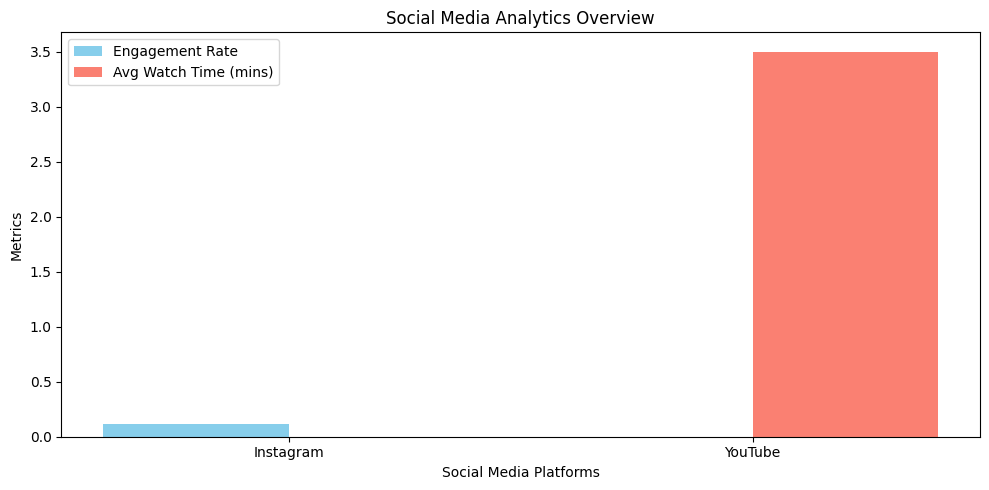

In [16]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

class AnalyticsVisualizer:
    def __init__(self, analytics_path="analytics_data.json"):
        self.analytics_path = analytics_path

    def load_analytics(self):
        """Load analytics data from local storage."""
        if not os.path.exists(self.analytics_path):
            print("No analytics data found!")
            return {}
        with open(self.analytics_path, "r") as file:
            return json.load(file)

    def visualize_data(self):
        """Generate visualizations from stored analytics data."""
        analytics_data = self.load_analytics()
        if not analytics_data:
            return

        # Separate platforms and metrics for visualization
        platforms = []
        engagement_rates = []
        avg_watch_times = []

        for key, data in analytics_data.items():
            platforms.append(key.split("_")[0])  # Extract platform name
            if "engagement_rate" in data:
                engagement_rates.append(data["engagement_rate"])
            else:
                engagement_rates.append(0)  # Use 0 if not applicable
            if "avg_watch_time" in data:
                avg_watch_times.append(data["avg_watch_time"])
            else:
                avg_watch_times.append(0)

        # Visualization: Bar chart for engagement rates
        x = np.arange(len(platforms))  # X-axis positions

        plt.figure(figsize=(10, 5))
        plt.bar(x - 0.2, engagement_rates, 0.4, label='Engagement Rate', color='skyblue')
        plt.bar(x + 0.2, avg_watch_times, 0.4, label='Avg Watch Time (mins)', color='salmon')

        plt.xticks(x, platforms)
        plt.xlabel("Social Media Platforms")
        plt.ylabel("Metrics")
        plt.title("Social Media Analytics Overview")
        plt.legend()
        plt.tight_layout()

        plt.show()

# --- USAGE EXAMPLE ---
if __name__ == "__main__":
    visualizer = AnalyticsVisualizer()
    visualizer.visualize_data()


# Conclusion:
This project represents a cutting-edge AI system designed to stress-test Gemini 1.5’s long context window while providing real-time, personalized recommendations to social media influencers and content creators. By implementing efficient context management, dynamic content suggestion algorithms, and user feedback loops, we’ve ensured that the system can scale to handle more than 100,000 tokens while maintaining relevance and context.
In conclusion, this approach demonstrates how we can build a sophisticated, scalable AI assistant capable of handling vast amounts of information in real-time while providing highly contextual, personalized advice for content creators and influencers. The key is in managing the context dynamically while ensuring that the system stays efficient and responsive regardless of the token limits.